# Figure 4 - Loss of heterozygosity

In [3]:
# load external dependencies
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.lines as lines
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
%matplotlib inline

import json, matplotlib
s = json.load( open("matplotlibrc.json") )
matplotlib.rcParams.update(s)

import glob, os, re
import numpy as np
import pandas as pd # (*) Pandas for data manipulation

# load internal dependencies
import colors,plot,stats,utils
from config import *
from utils import sgd_length
from paths import * # absolute file path for data directory

## Data import

### Length distribution of homozygosity tracts

In [4]:
# load data
loh_length_df = pd.read_csv(dir_data+'seq/loh-v1.0-data/histogram-data.tsv', sep='\t')

loh_length_df = loh_length_df.set_index("#50kb-bin-center")

loh_length_df = loh_length_df.reindex(columns=['HU','RM','YPD'])

loh_length_df.head()

,HU,RM,YPD
#50kb-bin-center,,,
25,0.732980,0.748970,0.750893
75,0.139939,0.152117,0.159386
125,0.052950,0.055077,0.052793
175,0.033283,0.020607,0.021708
225,0.012859,0.010116,0.008484


### Examples of loss-of-heterozygosity in clonal genome sequences

In [5]:
types = ('*consensus*.txt','*loh*.txt') # the tuple of file types'*consensus*.txt',*gt*.txt',
files = []
for t in types:
    files.extend(glob.glob(dir_data + 'seq/16.01.13.loh.data/'+t))

seq_loh_df = pd.DataFrame()

for file_ in files:
    
    df = pd.read_csv(file_, index_col=None, names=['chr_arabic','start','length','end','genotype'], sep='\t')
    
    f = re.split(r'[.-]+', os.path.basename(file_))

    df['background'] = f[0].split('_')[0]
    df['cross'] = f[0].split('_')[1]
    df['cross_rep'] = f[0].split('_')[2]
    df['selection'] = f[0].split('_')[3]
    df['selection_rep'] = f[0].split('_')[4]

    if len(f[0].split('_'))>7:
        df['population'] = '_'.join(f[0].split('_')[:-2])
        df['clone'] = f[0].split('_')[6]
        df['lineage'] = f[0].split('_')[7]
    else:
        df['population'] = '_'.join(f[0].split('_')[:-1])
        df['clone'] = ""
        df['lineage'] = f[0].split('_')[6]

    df['type'] = f[1]
    if f[1]!='gt':
        df['set'] = int(f[2].replace('set',''))
    else:
        df['set'] = ""
    
    seq_loh_df = seq_loh_df.append(df, ignore_index=True)

seq_loh_df = utils.chr_to_gw(seq_loh_df)

start = seq_loh_df[['selection','population','set','clone','lineage','type','chr_arabic','chr_roman','start','end','length','pos_start','genotype']]\
.rename(columns={'pos_start':'pos'})
end = seq_loh_df[['selection','population','set','clone','lineage','type','chr_arabic','chr_roman','start','end','length','pos_end','genotype']]\
.rename(columns={'pos_end':'pos'})

seq_loh_df = pd.concat([start, end]).sort_values('pos')

# seq_loh_df = seq_loh_df[seq_loh_df.length > 10]

seq_loh_df['lineage'] = seq_loh_df['lineage'].replace('A','subclone A')
seq_loh_df['lineage'] = seq_loh_df['lineage'].replace('B','subclone B')
seq_loh_df['lineage'] = seq_loh_df['lineage'].replace('C','subclone C')
seq_loh_df['lineage'] = seq_loh_df['lineage'].replace('D','subclone D')

# dummy
seq_loh_df['gene_sgd'] = ''

seq_loh_df['genotype'] = seq_loh_df['genotype'].astype(int)

# seq_loh_df = seq_loh_df[seq_loh_df['selection']=='HU']

# seq_loh_df = pd.concat([seq_loh_df, seq_dn_df], axis=0)

# seq_loh_df = seq_loh_df.replace({np.nan:'de novo'})

# seq_loh_df = seq_loh_df[seq_loh_df['population'].isin(['WAxNA_F12_2_HU_1_T32','WAxNA_F12_1_RM_3_T32'])]

# seq_loh_df = pd.pivot_table(seq_loh_df, 
#                             index=['selection','population','set','clone','lineage','type'], 
#                             columns=['chr_arabic','chr_roman','pos'])['genotype']

seq_loh_df.head()

,selection,population,set,clone,lineage,type,chr_arabic,chr_roman,start,end,length,pos,genotype,gene_sgd
0,HU,WAxNA_F12_1_HU_1_T32,1,,subclone A,consensus,1,I,2718,32682,48,2718,2,
16244,RM,WAxNA_F12_1_RM_3_T32,15,C3,subclone A,loh,1,I,2718,116457,443,2718,0,
8854,RM,WAxNA_F12_2_RM_2_T32,11,,bulk,consensus,1,I,2718,59145,203,2718,2,
16487,HU,WAxNA_F12_2_HU_1_T32,1,C1,subclone A,loh,1,I,2718,32682,48,2718,0,
16774,HU,WAxNA_F12_2_HU_1_T32,2,C2,bulk,loh,1,I,2718,56480,195,2718,0,


In [12]:
# load data
seq_mut_df = utils.load_data(dir_data+'seq/seq_dn_df_isec3.pickle')

seq_mut_df = seq_mut_df.rename(columns={'chrom':'chr_arabic', 'pos':'site'})
seq_mut_df['chr_roman'] = seq_mut_df['chr_arabic'].apply(utils.int_to_roman)
seq_mut_df = utils.chr_to_gw(seq_mut_df)

seq_mut_df = seq_mut_df[(seq_mut_df.time=='32')&\
                        (seq_mut_df.clone!='')&\
                        (seq_mut_df.selection!='YPD')].reset_index(drop=True)

# seq_dn_df['population'] = seq_dn_df['background']+seq_dn_df['cross']+seq_dn_df['cross_rep'].map(str)\
# +seq_dn_df['env_evo']+seq_dn_df['prop_rep'].map(str)+seq_dn_df['time'].map(str)

# seq_dn_df['group_label'] = seq_dn_df['group_label'].replace('_C','')

# seq_dn_df = seq_dn_df.set_index(['selection','population'])

# annotate zygosity
seq_mut_df.loc[(seq_mut_df['frequency']<0.01),'genotype'] = 0
seq_mut_df.loc[(seq_mut_df['frequency']>0.01)&(seq_mut_df['frequency']<0.99),'genotype'] = 1
seq_mut_df.loc[(seq_mut_df['frequency']>0.99),'genotype'] = 2
seq_mut_df['genotype'] = seq_mut_df['genotype'].astype(int)

# dummy
# seq_mut_df['set'] = ''
# seq_mut_df['lineage'] = ''

# seq_mut_df = seq_mut_df[seq_mut_df['population'].isin(['WAxNA_F12_2_HU_1_T32','WAxNA_F12_1_RM_3_T32'])]
# seq_dn_df = seq_dn_df[seq_dn_df['selection']=='HU']

# seq_dn_df = pd.pivot_table(seq_dn_df, 
#                             index=['selection','population','clone'], 
#                             columns=['chrom','pos','gene_sgd'])['frequency']

# seq_mut_df = seq_mut_df[seq_mut_df['gene_sgd'].isin(['DEP1','YNR066C','RNR2','RNR4','FPR1','TOR1'])]

seq_mut_df['type'] = 'de novo'

# seq_dn_df = seq_dn_df.set_index(['selection','population','clone'])

# seq_dn_df.frequency = seq_dn_df.frequency.fillna(0).astype(bool).astype(int)
seq_mut_df.head()

,sample_label,group_label,background,cross,cross_rep,selection,selection_rep,clone,gene_sgd,chr_arabic,...,amino_acids,impact,consequence,time,frequency,population,chr_roman,pos,genotype,type
0,WAxNA_F12_1_HU_1_T32_C2,WAxNA_F12_1_HU_1_C,WAxNA,F12,1,HU,1,C2,RNR4,7,...,R/G,moderate,missense_variant,32,1.000000,WAxNA_F12_1_HU_1_T32,VII,4595192,2,de novo
1,WAxNA_F12_2_HU_2_T32_C3,WAxNA_F12_2_HU_2_C,WAxNA,F12,2,HU,2,C3,MYO1,8,...,F/L,moderate,missense_variant,32,0.437500,WAxNA_F12_2_HU_2_T32,VIII,4982910,1,de novo
2,WAxNA_F12_2_RM_2_T32_C6,WAxNA_F12_2_RM_2_C,WAxNA,F12,2,RM,2,C6,FBA1,11,...,H,low,synonymous_variant,32,0.520000,WAxNA_F12_2_RM_2_T32,XI,6905067,1,de novo
3,WAxNA_F12_2_HU_2_T32_C3,WAxNA_F12_2_HU_2_C,WAxNA,F12,2,HU,2,C3,RNR4,7,...,R/I,moderate,missense_variant,32,1.000000,WAxNA_F12_2_HU_2_T32,VII,4595191,2,de novo
4,WAxNA_F12_1_HU_1_T32_C2,WAxNA_F12_1_HU_1_C,WAxNA,F12,1,HU,1,C2,SEF1,2,...,T,low,synonymous_variant,32,0.478261,WAxNA_F12_1_HU_1_T32,II,329218,1,de novo


In [7]:
columns=['selection','population','clone']
seq_mut_fixed_df = pd.merge(seq_mut_df, 
                            seq_loh_df[['selection','population','clone','set','lineage']].drop_duplicates(columns), 
                            on=columns, how='left')
#seq_mut_df.drop_duplicates(columns).set_index(columns)
seq_loh_fixed_df = pd.merge(seq_loh_df, 
                            seq_mut_df[['selection','population','clone']].drop_duplicates(columns), 
                            on=columns, how='left')
#seq_loh_df.drop_duplicates(columns).set_index(columns)

# seq_mut_df.loc[seq_mut_df.index.isin(seq_loh_fixed_df.index),['set']] = seq_loh_fixed_df['set']
# # seq_loh_fixed_df.loc[seq_loh_fixed_df.set_index(columns).index.isin(seq_mut_fixed_df.index),['gene_sgd']] = seq_mut_fixed_df['gene_sgd']

# seq_mut_df = seq_mut_df.reset_index()
# # seq_loh_fixed_df = seq_loh_fixed_df.reset_index()

seq_dn_df = pd.concat([seq_loh_fixed_df, seq_mut_fixed_df], axis=0).reset_index(drop=True)

seq_dn_df = pd.pivot_table(seq_dn_df, 
                           index=['selection','population','set','clone','lineage','type'], 
                           columns=['chr_arabic','chr_roman','pos','gene_sgd'])['genotype']

### Fluctuation assay

In [9]:
# read xlsx file containing the competition assay data
loh_fluctuation_df = pd.ExcelFile(dir_supp+'figures/figureSX_LOH_assay/LOH_assay_raw_data_IVG_new.xlsx')
loh_fluctuation_df = loh_fluctuation_df.parse('New', keep_default_na=False, na_values='NaN')

loh_fluctuation_df['5-FOA+'] = loh_fluctuation_df['5FOA']*200/10
loh_fluctuation_df['Total 5-FOA'] = loh_fluctuation_df['YPD']*1000000*2/40

loh_fluctuation_df['LOH rate'] = loh_fluctuation_df['5-FOA+']/loh_fluctuation_df['Total 5-FOA']

from scipy import stats

loh_fluctuation_df = loh_fluctuation_df.groupby(['background','environment'])\
.agg([np.mean, stats.sem])

loh_fluctuation_df = loh_fluctuation_df.ix[['WA/WA','NA/NA','WA/NA']]
loh_fluctuation_df = loh_fluctuation_df.unstack('background')

loh_fluctuation_df.head()

biol_rep                                           tech_rep        \
                mean                   sem                         mean         
background     WA/WA NA/NA WA/NA     WA/WA     NA/NA     WA/NA    WA/WA NA/NA   
environment                                                                     
HU               2.5   2.5   2.5  0.422577  0.422577  0.422577      1.5   1.5   
RM               2.5   2.5   2.5  0.422577  0.422577  0.422577      1.5   1.5   
YPD              2.5   2.5   2.5  0.422577  0.422577  0.422577      1.5   1.5   

                               ...    Total 5-FOA                 \
                        sem    ...           mean            sem   
background  WA/NA     WA/WA    ...          WA/NA          WA/WA   
environment                    ...                                 
HU            1.5  0.188982    ...         237500   37796.447301   
RM            1.5  0.188982    ...        3662500  329628.782009   
YPD           1.5  0.188982    ...        4237500  957396.021956   

                                           LOH rate                      \
                                               mean                       
background           NA/NA          WA/NA     WA/WA     NA/NA     WA/NA   
environment                                                               
HU           459910.705619   86473.571520  0.016617  0.002876  0.004080   
RM           434293.093511  302924.731340  0.000352  0.000990  0.000044   
YPD          316712.676795  342228.776865  0.000090  0.000209  0.000038   

                                           
                  sem                      
background      WA/WA     NA/NA     WA/NA  
environment                                
HU           0.004539  0.000354  0.000876  
RM           0.000181  0.000114  0.000021  
YPD          0.000022  0.000037  0.000009  

[3 rows x 42 columns]

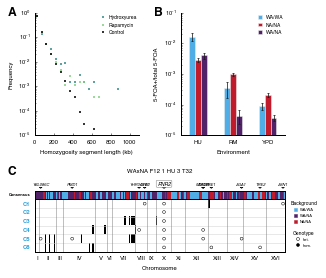

In [10]:
fig = plt.figure(figsize=(4, 4), dpi=300)

grid = gridspec.GridSpec(2, 2, height_ratios=[2, 1], hspace=0.6, wspace=0.4)

gs = {}
gs['length'] = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=grid[0,0])
gs['fluctuation'] = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=grid[0,1])
gs['loh'] = gridspec.GridSpecFromSubplotSpec(7, 1, subplot_spec=grid[1,:], hspace=0)

### top left panel ###
ax1 = plt.subplot(gs['length'][:])
ax1.text(-0.175, 1.05, 'A', transform=ax1.transAxes,
         fontsize=12, fontweight='bold', va='top', ha='right')

colors = [dict_environment['color'][e] for e in loh_length_df.columns]

# loh_length_df = loh_length_df.rename(columns=dict_environment['short_label'])


loh_length_df.rename(columns=dict_environment['short_label'])\
.plot(ax=ax1, logy=True, color=colors, style='.', marker='o', ms=2., mec='none', legend=False)

utils.simple_axes(ax1)
ax1.set_xlim(0,1.1E3)
ax1.set_xlabel('Homozygosity segment length (kb)')
ax1.set_ylabel('Frequency')

ax1.legend(frameon=False, loc='upper right', 
           borderaxespad=0., prop={'size':5},
           handlelength=0.75)

### top right panel ###
ax2 = plt.subplot(gs['fluctuation'][:])
ax2.text(-0.175, 1.05, 'B', transform=ax2.transAxes,
         fontsize=12, fontweight='bold', va='top', ha='right')

colors = [dict_background['color'][b] for b in loh_fluctuation_df['LOH rate','mean'].columns] 
loh_fluctuation_df['LOH rate','mean'].plot(ax=ax2, kind='bar', yerr = loh_fluctuation_df['LOH rate','sem'], 
                  color=colors, legend=False,
                  error_kw=dict(ecolor='0.1', lw=.75, capsize=.75, capthick=.75))

utils.simple_axes(ax2)
ax2.set_yscale('log')
ax2.set_xlabel('Environment')
ax2.set_xticklabels(loh_fluctuation_df.index.get_level_values('environment'), minor=False, rotation=0)
ax2.set_ylabel('5-FOA+/total 5-FOA')

ax2.legend(frameon=False, loc='upper right', 
           borderaxespad=0., prop={'size':5},
           handlelength=0.75)

### bottom panel ###
ax3 = plt.subplot(gs['loh'][:1])

# make a color map of fixed colors
cmap = mpl.colors.ListedColormap([dict_background['color']['WA'], 
                                  dict_background['color']['WAxNA'], 
                                  dict_background['color']['NA']])
bounds=[0,1,2]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

sdn = seq_dn_df.ix['HU','WAxNA_F12_1_HU_3_T32']

indexer = [slice(None)]*len(sdn.index.names)
indexer[sdn.index.names.index('type')] = ['consensus']
gc = sdn.loc[tuple(indexer),:].dropna(axis=1, how='all')

x = gc.columns.get_level_values('pos').values
y = np.arange(len(gc.index))
data = gc.values

plot.heatmap(np.r_[x, x.max()+1], np.r_[y, y.max()+1], data, 
             ax3, '', '', '', [], [], cmap=cmap, vmin=0, vmax=2)

ax3.set_title('WAxNA F12 1 HU 3 T32', fontsize=6, y=2.5)

ylabels = ['Consensus']
ax3.set_yticks(np.arange(len(ylabels)) + 0.5, minor=True)
ax3.set_yticklabels(ylabels, fontweight='bold', va='center', minor=True)

# show de novo mutations
indexer = [slice(None)]*len(sdn.index.names)
indexer[sdn.index.names.index('type')] = ['de novo']
gn_all = sdn.loc[tuple(indexer),:].dropna(axis=1, how='all')
        
labels = gn_all.columns.get_level_values('gene_sgd')
loc = zip(gn_all.columns.get_level_values('pos'), [-.25]*gn_all.shape[1])

for l, xy in zip(labels, loc):
    trans = ax3.get_xaxis_transform() # x in data units, y in axes fraction
    ann = ax3.annotate(l, xy=xy, xytext=(0, 2), textcoords='offset points',
                       arrowprops=dict(arrowstyle='wedge,tail_width=0.7', color='black'),
                       fontsize=(5 if l in ['RNR2','RNR4','FPR1','TOR1'] else 4), 
                       style='italic', annotation_clip=False, va='bottom', ha='center', 
                       bbox=(dict(facecolor='none', edgecolor='gray', boxstyle='round,pad=.2')\
                             if l in ['RNR2','RNR4','FPR1','TOR1'] else \
                             dict(facecolor='none', edgecolor='none', boxstyle='round,pad=.2')))

ax4 = plt.subplot(gs['loh'][1:])

ax4.text(-0.075, 1.65, 'C', transform=ax4.transAxes,
         fontsize=12, fontweight='bold', va='top', ha='right')

indexer = [slice(None)]*len(sdn.index.names)
indexer[sdn.index.names.index('type')] = ['loh']
gl = sdn.loc[tuple(indexer),:].dropna(axis=1, how='all')

x = gl.columns.get_level_values('pos').values
y = np.arange(len(gl.index.get_level_values('clone')))
data = gl.values

# make a color map of fixed colors
cmap = mpl.colors.ListedColormap(['w', 'k'])
bounds=[0,1]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

plot.heatmap(np.r_[x, x.max()+1], np.r_[y, y.max()+1], data, ax4, '', '', '', [], [], cmap=cmap)

lineage = gl.index.get_level_values('lineage').unique()[0]
ax4.tick_params(axis='y', colors=dict_lineages[lineage]['fill'], width=5, which='both')

# show de novo mutations
indexer = [slice(None)]*len(sdn.index.names)
indexer[sdn.index.names.index('type')] = ['de novo']
gn = sdn.loc[tuple(indexer),:].dropna(axis=1, how='all')
            
for i,(k,g) in enumerate(gn.groupby(level='clone')):
    g = g.dropna(axis=1)
    x = g.columns.get_level_values('pos').values
    y = [i+.5]*len(x)
    data = g.values.flatten()
    ax4.scatter(x, y, 
                facecolors=[dict_genotype['color'][int(x)] for x in data],
                edgecolors='k', s=8, zorder=3)

ylabels = gl.index.get_level_values('clone')
ax4.set_yticks(np.arange(len(ylabels)) + 0.5)
ax4.set_yticklabels(ylabels, fontweight='bold', va='center')
[ax4.axhline(g, lw=0.5, ls="-", color="lightgray") for g in np.arange(len(ylabels))]

xlabels = sgd_length.chr_start + (sgd_length.chr_end - sgd_length.chr_start)/2.
xstart = sgd_length.chr_start
ax4.set_xticks(xlabels)
ax4.set_xticklabels(sgd_length.chr_arabic.apply(utils.int_to_roman))
xgrid=[xst+1. for xst in list(set(xstart))]
[ax4.axvline(g, lw=0.5, ls="-", color="gray") for g in xgrid]

ax4.set_xlabel('Chromosome')

# set legend    
wt_artist = patches.Rectangle((0,0), width=1, height=1, color=dict_background['color']['WA/WA'])
het_artist = patches.Rectangle((0,0), width=1, height=1, color=dict_background['color']['WA/NA'])
hom_artist = patches.Rectangle((0,0), width=1, height=1, color=dict_background['color']['NA/NA'])
    
leg1 = ax3.legend([wt_artist,het_artist,hom_artist], ['WA/WA','WA/NA','NA/NA'], 
                  bbox_to_anchor=(1.075, -1.5), ncol=1,
                  frameon=False, loc='center',
                  borderaxespad=0, handlelength=0.75, 
                  title='Background', prop={'size':4})
    
het_artist = lines.Line2D((0,1),(0,0), mec='k', mfc=dict_genotype['color'][1], 
                          marker='o', markersize=3, linestyle='')
hom_artist = lines.Line2D((0,1),(0,0), mec='k', mfc=dict_genotype['color'][2],
                          marker='o', markersize=3, linestyle='')
    
leg2 = ax4.legend([het_artist,hom_artist], ['het.','hom.'], 
                  bbox_to_anchor=(1.075, .25), ncol=1,
                  frameon=False, loc='center',
                  borderaxespad=0, handlelength=0.75, 
                  title='Genotype', prop={'size':4})
        
for leg in [leg1,leg2]:
    plt.setp(leg.get_title(),fontsize=5)

# axes limits
for ax in fig.get_axes():
    ax.xaxis.label.set_size(6)
    ax.yaxis.label.set_size(6)
    ax.tick_params(axis='both', which='major', size=2, labelsize=6)
    ax.tick_params(axis='both', which='minor', size=1, labelsize=4)

fig.savefig(dir_paper+'figures/figure4/figure4.png', dpi=300, bbox_inches='tight')
fig.savefig(dir_paper+'figures/figure4/figure4.svg', dpi=300, bbox_inches='tight')
plt.show()

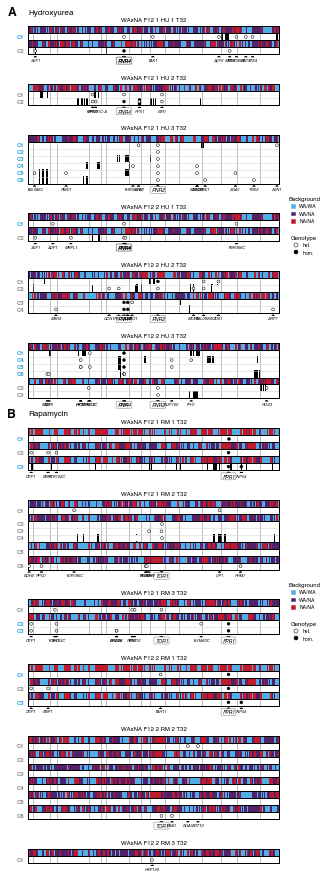

In [42]:
ncols = 4
nrows = 14
fig = plt.figure(figsize=(ncols, nrows), dpi=300)

indexer = [slice(None)]*len(seq_dn_df.index.names)
indexer[seq_dn_df.index.names.index('type')] = ['consensus','loh']
seq_dn_df_sliced = seq_dn_df.loc[tuple(indexer),:].dropna(axis=1, how='all')

shape = pd.DataFrame({k: 
x.shape for k,x in seq_dn_df_sliced.groupby(level=['selection','population'])
})

ygrid = shape.ix[0].values
grid = gridspec.GridSpec(len(ygrid), 1, height_ratios=ygrid, hspace=0.7)

gs = {}

###  ###

for ii, ((e,p), sdf) in enumerate(seq_dn_df.groupby(level=['selection','population'])):

    idx = 0
    
    nrows = ygrid[ii]
    ncols = 1
    gs[(e,p)] = gridspec.GridSpecFromSubplotSpec(nrows, ncols,
                                                 subplot_spec=grid[ii],
                                                 hspace=0, wspace=0)
    
    for jj, (s, jdf) in enumerate(sdf.groupby(level='set')):
        
        indexer = [slice(None)]*len(jdf.index.names)
        indexer[jdf.index.names.index('type')] = ['consensus']
        gc = jdf.loc[tuple(indexer),:].dropna(axis=1, how='all')

        ax1 = plt.subplot(gs[(e,p)][idx:idx+len(gc)])

        idx += len(gc)
        
        # set title
        ax1.set_title(p)
        
        if len(gc) > 0:
            x = gc.columns.get_level_values('pos').values
            y = np.arange(len(gc.index))
            data = gc.values
            
            # make a color map of fixed colors
            cmap = mpl.colors.ListedColormap([dict_background['color']['WA'], 
                                              dict_background['color']['WAxNA'], 
                                              dict_background['color']['NA']])
            bounds = [0,1,2]
            norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
            
            title = (p.replace('_',' ') if jj==0 else '')
            xlabel= ''
            ylabel= ''
            xticklabels = []
            yticklabels = []
    
            plot.heatmap(np.r_[x, x.max()+1], np.r_[y, y.max()+1], data, 
                         ax1, '', xlabel, ylabel, xticklabels, yticklabels, cmap=cmap, vmin=0, vmax=2)
        
            ax1.set_title(title, fontsize=6)

        indexer = [slice(None)]*len(jdf.index.names)
        indexer[jdf.index.names.index('type')] = ['loh']
        gl = jdf.loc[tuple(indexer),:].dropna(axis=1, how='all')
        
        ax2 = plt.subplot(gs[(e,p)][idx:idx+len(gl)], sharex=ax1)
 
        idx += len(gl)
        
        if len(gl) > 0:
            x = gl.columns.get_level_values('pos').values
            y = np.arange(len(gl.index))#.get_level_values('isolate')))
            data = gl.values
    
            # make a color map of fixed colors
            cmap = mpl.colors.ListedColormap(['w', 'k'])
            bounds=[0,1]
            norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

            plot.heatmap(np.r_[x, x.max()+1], np.r_[y, y.max()+1], data, ax2, '', '', '', [], [], cmap=cmap)
            
            lineage = gl.index.get_level_values('lineage').unique()[0]
            ax2.tick_params(axis='y', colors=dict_lineages[lineage]['fill'], width=5, which='both')

        # show de novo mutations
        indexer = [slice(None)]*len(jdf.index.names)
        indexer[jdf.index.names.index('type')] = ['de novo']
        gn = jdf.loc[tuple(indexer),:].dropna(axis=1, how='all')
        
        if len(gn) > 0:
            
            for i,(k,g) in enumerate(gn.groupby(level='clone')):
                g = g.dropna(axis=1)
                x = g.columns.get_level_values('pos').values
                y = [i+.5]*len(x)
                data = g.values.flatten()
                ax2.scatter(x, y, 
                            facecolors=[dict_genotype['color'][int(x)] for x in data],
                            edgecolors='k', s=8, zorder=3)

        # set grid
        xlabels = sgd_length.chr_start + (sgd_length.chr_end - sgd_length.chr_start)/2.
        xstart = sgd_length.chr_start
        if ii<(len(seq_loh_df.index)-1):
            ax2.set_xticks([])
            ax2.set_xticklabels([])
        else:
            ax2.set_xticks(xlabels, minor=False)
            ax2.set_xticklabels(sgd_length.chr_arabic.apply(utils.int_to_roman), minor=False)
            ax2.set_xlabel('Chromosome')
        xgrid=[xst+1. for xst in list(set(xstart))]
        [ax2.axvline(g, lw=0.5, ls="-", color="gray") for g in xgrid]
    
        ylabels = gl.index.get_level_values('clone')
        ax2.set_yticks(np.arange(len(ylabels)) + 0.5, minor=False)
        ax2.set_yticklabels(ylabels, fontweight='bold', va='center', minor=False)
        [ax2.axhline(g, lw=0.5, ls="-", color="lightgray") for g in np.arange(len(ylabels))]
    
    # show de novo mutations
    indexer = [slice(None)]*len(sdf.index.names)
    indexer[sdf.index.names.index('type')] = ['de novo']
    gn_all = sdf.loc[tuple(indexer),:].dropna(axis=1, how='all')
        
    labels = gn_all.columns.get_level_values('gene_sgd')
    loc = zip(gn_all.columns.get_level_values('pos'), [gn.shape[0]+.25]*gn_all.shape[1])

    for l, xy in zip(labels, loc):     
        trans = ax2.get_xaxis_transform() # x in data units, y in axes fraction
        ann = ax2.annotate(l, xy=xy, xytext=(0, -2), textcoords='offset points',
                           arrowprops=dict(arrowstyle='wedge,tail_width=0.7', color='black'),
                           fontsize=(5 if l in ['RNR2','RNR4','FPR1','TOR1'] else 4), 
                           style='italic', annotation_clip=False, va='top', ha='center', 
                           bbox=(dict(facecolor='none', edgecolor='gray', boxstyle='round,pad=.2')\
                                if l in ['RNR2','RNR4','FPR1','TOR1'] else \
                                 dict(facecolor='none', edgecolor='none', boxstyle='round,pad=.2')))
        
# set panel labels
ax1 = plt.subplot(gs['HU','WAxNA_F12_1_HU_1_T32'][(0,0)])
ax1.text(-0.05, 3,  chr(ord('A')), transform=ax1.transAxes,
         fontsize=12, fontweight='bold', va='center', ha='right')
ax1.text(0, 3,  dict_environment['short_label']['HU'], transform=ax1.transAxes,
         fontsize=8, va='center', ha='left')

ax1 = plt.subplot(gs['RM','WAxNA_F12_1_RM_1_T32'][(0,0)])
ax1.text(-0.05, 3,  chr(ord('B')), transform=ax1.transAxes,
         fontsize=12, fontweight='bold', va='center', ha='right')
ax1.text(0, 3,  dict_environment['short_label']['RM'], transform=ax1.transAxes,
         fontsize=8, va='center', ha='left')

# set legend
for k, xy in zip([('HU','WAxNA_F12_2_HU_1_T32'),('RM','WAxNA_F12_1_RM_3_T32')],[(2,0),(2,0)]):
    ax2 = plt.subplot(gs[k][(0,0)])
    
    wt_artist = patches.Rectangle((0,0), width=1, height=1, color=dict_background['color']['WA/WA'])
    het_artist = patches.Rectangle((0,0), width=1, height=1, color=dict_background['color']['WA/NA'])
    hom_artist = patches.Rectangle((0,0), width=1, height=1, color=dict_background['color']['NA/NA'])
    
    leg1 = ax2.legend([wt_artist,het_artist,hom_artist], ['WA/WA','WA/NA','NA/NA'], 
                      bbox_to_anchor=(1.1, 1.5), ncol=1,
                      frameon=False, loc='center',
                      borderaxespad=0, handlelength=0.75, 
                      title='Background', prop={'size':5})
    
    ax2 = plt.subplot(gs[k][(2,0)])

    het_artist = lines.Line2D((0,1),(0,0), mec='k', mfc=dict_genotype['color'][1], 
                              marker='o', markersize=4, linestyle='')
    hom_artist = lines.Line2D((0,1),(0,0), mec='k', mfc=dict_genotype['color'][2],
                              marker='o', markersize=4, linestyle='')
    
    leg2 = ax2.legend([het_artist,hom_artist], ['het.','hom.'], 
                      bbox_to_anchor=(1.1, -1.5), ncol=1,
                      frameon=False, loc='center',
                      borderaxespad=0, handlelength=0.75, 
                      title='Genotype', prop={'size':5})
        
    for leg in [leg1,leg2]:
        plt.setp(leg.get_title(),fontsize=6)
    
# axes limits
for ax in fig.get_axes():
    ax.xaxis.label.set_size(6)
    ax.yaxis.label.set_size(6)
    ax.tick_params(axis='both', which='major', size=2, labelsize=6)
    ax.tick_params(axis='both', which='minor', size=1, labelsize=4)

fig.savefig(dir_supp+'figures/figureSX_seq_loh/figureSX_seq_loh.png', dpi=300, bbox_inches='tight')
fig.savefig(dir_supp+'figures/figureSX_seq_loh/figureSX_seq_loh.svg', dpi=300, bbox_inches='tight')
plt.show()